In [1]:
import warnings
warnings.filterwarnings("ignore")
import json
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
import random
import torch
import tqdm
from PIL import Image
from pathlib import Path
from collections import defaultdict
import sys
print(os.path.abspath('..'))
sys.path[0]=os.path.abspath('..')
print(os.path.abspath('..'))
import torchvision.transforms as transforms
import argparse
from torchvision.transforms.functional import InterpolationMode
from extras_ import convert_sents_to_features, BertLayer
from finetune import ContextualBLIP
from blip_finetune import ContextualBLIP as BLIP
from finetune_notf import ContextualBLIP as Adapter_BLIP
from volta_src.config import BertConfig
import yaml
import torch.nn as nn
from utils import pre_caption
parser = argparse.ArgumentParser()
parser.add_argument('--valid_descr_path', type=str, default='dataset/valid_data.json')
parser.add_argument('--train_descr_path', type=str, default='dataset/train_data.json')
parser.add_argument('--imgs_path', type=str, default='dataset/image-sets')
parser.add_argument("--add_input", action="store_true",default=True)
parser.add_argument("--positional", action="store_true",default=True)
parser.add_argument("--transformer_layers", default=2, type=int)
parser.add_argument("--all_pos", action="store_true",default=False)
parser.add_argument("-a", "--activation", default='relu')
parser.add_argument("-s", "--logit_scale", default=1000)
parser.add_argument("--frozen_blip", action="store_true",default=True)
args = parser.parse_args([])

/home/lhl/Adapter-BLIP
/home/lhl/Adapter-BLIP


In [2]:
# IMAGECODE
print(os.path.abspath('.'))
print(sys.path)
img_dirs = args.imgs_path
print(os.path.exists('dataset/valid_data.json'))
valid_data = json.load(open(args.valid_descr_path, 'r'))
valid = []
for img_dir, data in valid_data.items():
    for img_idx, text in data.items():
        valid.append((img_dir, img_idx, text))
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f'DEVICE USED: {device}')

/home/lhl/Adapter-BLIP
['/home/lhl/Adapter-BLIP', '/home/lhl/anaconda3/envs/blip/lib/python39.zip', '/home/lhl/anaconda3/envs/blip/lib/python3.9', '/home/lhl/anaconda3/envs/blip/lib/python3.9/lib-dynload', '', '/home/lhl/anaconda3/envs/blip/lib/python3.9/site-packages', '/home/lhl/anaconda3/envs/blip/lib/python3.9/site-packages/clip-1.0-py3.9.egg', '/home/lhl/anaconda3/envs/blip/lib/python3.9/site-packages/ftfy-6.1.1-py3.9.egg', '/home/lhl/anaconda3/envs/blip/lib/python3.9/site-packages/wcwidth-0.2.6-py3.9.egg']
True
DEVICE USED: cuda


In [3]:
# 模型路径
blip_model_path = 'Models/blip/blip_0.3623_19.pt'
adater_blip_model_path = 'Models/finetune/0.25_2d_42/10/0.3719_17.pt'

bert_config = json.load(open('vilbert-and-bert-config.json', 'r'))

adater_blip = Adapter_BLIP(bert_config, args,pretrain=False).cuda()
checkpoint = torch.load(adater_blip_model_path)
msg = adater_blip.load_state_dict(checkpoint['model_state_dict'],strict= False)
print(msg)
blip = BLIP(bert_config, args,pretrain=False).cuda()
checkpoint = torch.load(blip_model_path)
blip.load_state_dict(checkpoint['model_state_dict'],strict= False)

adater_blip.cuda()
adater_blip.eval()
blip.cuda()
blip.eval()

preprocess = transforms.Compose([
    transforms.Resize((224,224),interpolation=InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
    ]) 

reduction: 2
<All keys matched successfully>


In [4]:
from matplotlib import pyplot as plt 
import numpy as np
np.set_printoptions(precision = 3)

def find_by_text(dataset, text):
    for img_dir, img_idx, t in tqdm.tqdm(dataset):
        if text == t:
            return img_dir,img_idx,text
    return False

def plt_logits(logits):
    plt.imshow(logits,cmap='Greys')
    ax = plt.gca()
    
    plt.axis('off')
    for i in range(logits.size):
        text = plt.text(i,0, str(round(logits[0,i],3)), ha="center", va="center", color="w")
        rect = plt.Rectangle((-0.5+i,-0.51),1,1,fill=False,linewidth=1)
        ax.add_patch(rect)
    #plt.tight_layout()

In [5]:
caption = 'the transition image into the one of the lady in blue from the one where bags where hang up'
caption2 = 'There is picture overlay with the first picture having slightly more visibility than the second. '
caption3 = "Two hands are visible. The hand on the left is very blurry and in the upper left corner."

ground truth: 0 blip: 3 ours: 0
There is a person in white on the left side of the image who is just about to serve the ball with one hand. 
MSR-VTT-videoTestVideo_video8465-shot1_2


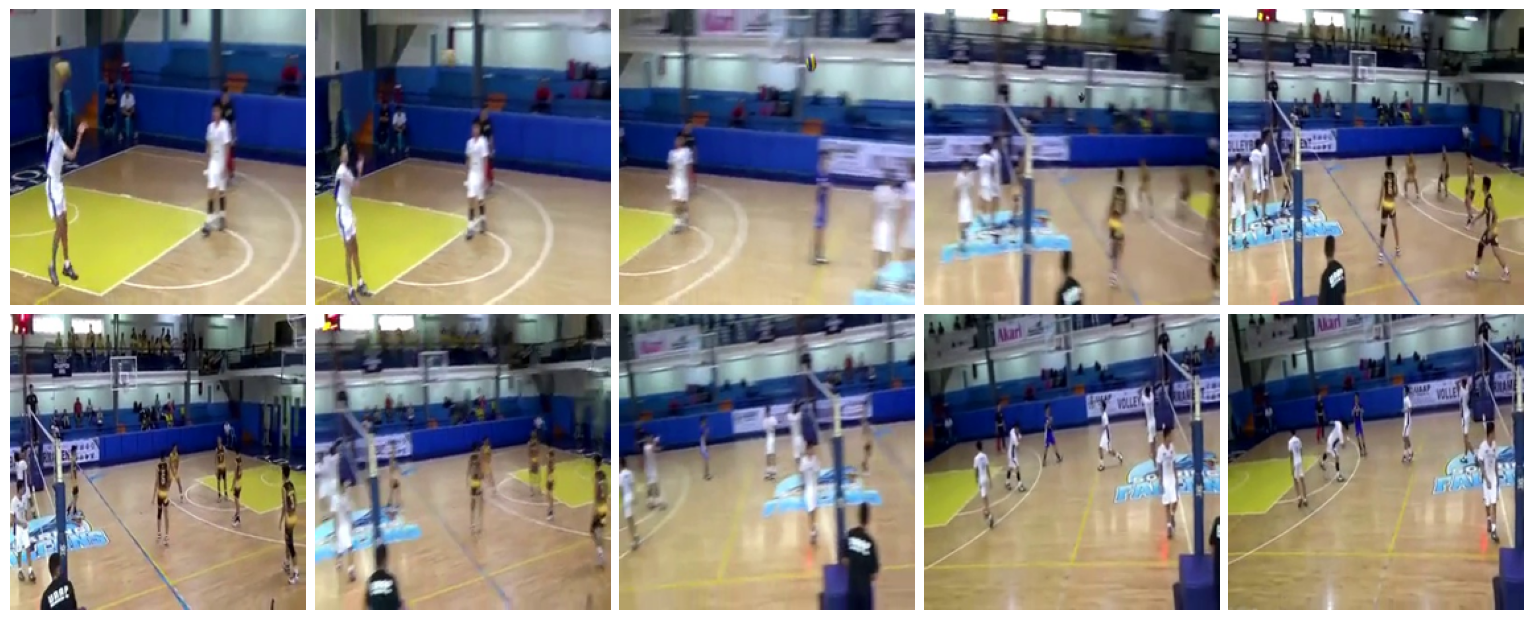

In [7]:
random.shuffle(valid)
with torch.no_grad():


    record = {}
    record['open-images-239_002b9f388457ab98'] = 1
    record['MSR-VTT-videoTestVideo_video8242-shot2_1'] = 1
    record['MSR-VTT-videoTestVideo_video9044-shot0_1'] = 1 #可能可以
    record['MSR-VTT-videoTestVideo_video9903-shot1_3'] = 1
    record['MSR-VTT-videoTestVideo_video9973-shot1_1'] = 1
    record['MSR-VTT-videoTestVideo_video8310-shot1_5'] = 1
    record['MSR-VTT-videoTestVideo_video7954-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video7686-shot3_0'] = 1
    record['MSR-VTT-videoTestVideo_video8747-shot1_1'] = 1
    record['MSR-VTT-videoTestVideo_video8547-shot1_1'] = 1
    record['MSR-VTT-videoTestVideo_video9454-shot0_2'] = 1
    record['MSR-VTT-videoTestVideo_video8700-shot3_2'] = 1
    record['MSR-VTT-videoTestVideo_video8936-shot1_1'] = 1
    record['MSR-VTT-videoTestVideo_video9412-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video8721-shot1_1'] = 1
    record['MSR-VTT-videoTestVideo_video8574-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video9677-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video9649-shot1_5'] = 1
    record['MSR-VTT-videoTestVideo_video9095-shot1_1'] = 1
    record['video-storytelling-videocamping_EytINruY3-U-shot37_0'] = 1
    record['MSR-VTT-videoTestVideo_video9402-shot1_1'] = 1
    record['YouCook-video0017-shot13_2'] = 1
    record['video-storytelling-videocamping_EytINruY3-U-shot47_0'] = 1
    record['video-storytelling-videobirthday__amwPjAcoC8-shot15_0'] = 1
    record['video-storytelling-videobirthday__amwPjAcoC8-shot21_0'] = 1
    record['MSR-VTT-videoTestVideo_video8777-shot1_1'] = 1
    record['video-storytelling-videocamping_1OzbiB1TIWI-shot12_24'] = 1
    record['MSR-VTT-videoTestVideo_video9876-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video9623-shot1_2'] = 1
    record['open-images-2526_07168590a17ecdfd'] = 1
    record['open-images-1427_2bb96eadec738c2e'] = 1
    record['MSR-VTT-videoTestVideo_video9319-shot1_2'] = 1
    record['MSR-VTT-videoTestVideo_video8156-shot3_1'] = 1
    record['MSR-VTT-videoTestVideo_video7692-shot2_1'] = 1
    record['MSR-VTT-videoTestVideo_video9968-shot3_0'] = 1
    record['MSR-VTT-videoTestVideo_video7657-shot2_0'] = 1
    record['MSR-VTT-videoTestVideo_video8403-shot1_1'] = 1
    record['YouCook-video0063-shot37_0'] = 1
    record['MSR-VTT-videoTestVideo_video7689-shot1_0'] = 1
    record['YouCook-video0035-shot7_0'] = 1
    record['MSR-VTT-videoTestVideo_video8427-shot1_2'] = 1
    record['MSR-VTT-videoTestVideo_video7113-shot1_1'] = 1
    record['MSR-VTT-videoTestVideo_video9651-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video9446-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video9256-shot1_2'] = 1
    record['MSR-VTT-videoTestVideo_video8595-shot1_0'] = 1
    record['MSR-VTT-videoTestVideo_video8144-shot2_2'] = 1
    record['YouCook-video0017-shot2_2'] = 1
    record['MSR-VTT-videoTestVideo_video8465-shot1_2'] = 1
    record['YouCook-video0050-shot1_0'] = 1

    for img_dir, img_idx, text_ in valid:

        flag = 0
        temporal = ['after','during', 'about to', 'beginning to', 'end to']
        for word in temporal:
            if word in text_:
                flag = 1
                break
        if flag == 0:
            continue
        
        # if (img_dir in record):
        #     continue
        #img_dir, img_idx, text_ = find_by_text(valid,caption3)

        if (img_dir == 'MSR-VTT-videoTestVideo_video8465-shot1_2'):
            text = [pre_caption(text_)]
            img_idx = int(img_idx)
            img_files = list((Path(img_dirs) / img_dir).glob("*.jpg"))
            img_files = sorted(img_files, key=lambda x: int(str(x).split('/')[-1].split('.')[0][3:]))
            images = [Image.open(photo_file).convert("RGB") for photo_file in img_files]
            preprocess = transforms.Compose([
                transforms.Resize((224,224),interpolation=InterpolationMode.BICUBIC),
                transforms.ToTensor(),
                transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711)),
                ])  
            images = [preprocess(image) for image in images]
            image = torch.stack(images).to(device)
            
            if "open-images" in str(img_dir):
                pos_mask = torch.zeros((10, 1)).cuda()
            else:
                pos_mask = torch.ones((10, 1)).cuda()
            logits1 = blip(image, text,pos_mask)
            pred1 = torch.argmax(logits1.squeeze()).squeeze()
            logits2 = adater_blip(image, text,pos_mask)
            pred2 = torch.argmax(logits2.squeeze()).squeeze()

            max_element = logits2.squeeze()[pred2]
            second_max_element = 0;
            for element in logits2.squeeze():
                if element < max_element and element > second_max_element:
                    second_max_element = element
            
            diff = max_element - second_max_element

            if (pred1.cpu().item() != img_idx and pred2.cpu().item() == img_idx and diff > 0.01):
                break

from matplotlib import pyplot as plt
import numpy as np

print("ground truth:",img_idx,"blip:",pred1.cpu().item(),'ours:',pred2.cpu().item())
print(text_)
logits1 = torch.softmax(logits1,dim=0).reshape(-1)
logits2 = torch.softmax(logits2,dim=0).reshape(-1)
logits1 = logits1.cpu().numpy().reshape(1,-1)
logits2 = logits2.cpu().numpy().reshape(1,-1)
print(img_dir)

fig, ax = plt.subplots(2, 5, figsize=(19.53125, 7.8125))

images = [Image.open(photo_file).convert("RGB").resize((224, 224)) for photo_file in img_files]
for i, img in enumerate(images):
    ax[i // 5, i % 5].imshow(np.array(img))
    ax[i // 5, i % 5].axis('off')

plt.subplots_adjust(wspace=0.03, hspace=0.03)  
plt.show()



array([[0.171, 0.12 , 0.033, 0.182, 0.062, 0.106, 0.036, 0.15 , 0.086,
        0.054]], dtype=float32)

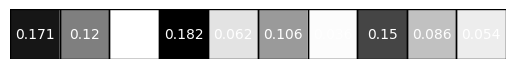

In [17]:
plt_logits(logits1)
logits1

array([[0.304, 0.085, 0.012, 0.069, 0.048, 0.088, 0.02 , 0.136, 0.145,
        0.092]], dtype=float32)

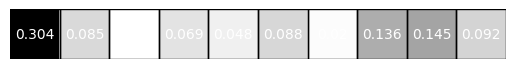

In [19]:
plt_logits(logits2)
logits2

In [18]:
logits1

array([[0.171, 0.12 , 0.033, 0.182, 0.062, 0.106, 0.036, 0.15 , 0.086,
        0.054]], dtype=float32)

### Case Study 想法
上面的文本存在几个判断条件，分别为"the lady in blue"、"bags were hang up"和"the transition image"
通过模型输出各图的logits，我们可以体现模型是否真正关注到这些判定信息
下面分别用三个子条件的文本进行检索，可以看到除了"the lady in blue"效果不好，另两个效果都很不错

In [14]:
subcaption1 = "There is a person who is just about to serve the ball with one hand."
subcaption2 = "There is an image of them swimming horizontally layered on them but is not as in focus as them standing vertically."
subcaption3 = "It's a little blurry."
subcaption4 = "the first picture having slightly more visibility than the second."
subcaption5 = "The person on the left has their mouth still closed."

ground truth: 0 ours: 0
['there is a person who is just about to serve the ball with one hand']
[[0.171 0.12  0.033 0.182 0.062 0.106 0.036 0.15  0.086 0.054]]


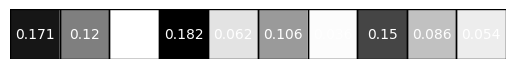

In [15]:
with torch.no_grad():
    text = [pre_caption(subcaption1)]

    logits1 = blip(image, text,pos_mask)
    pred1 = torch.argmax(logits1.squeeze()).squeeze()

    logits2 = adater_blip(image, text,pos_mask)
    pred2 = torch.argmax(logits2.squeeze()).squeeze()

    logits1 = torch.softmax(logits1,dim=0).reshape(-1)
    logits2 = torch.softmax(logits2,dim=0).reshape(-1)
    logits1 = logits1.cpu().numpy().reshape(1,-1)
    logits2 = logits2.cpu().numpy().reshape(1,-1)
    
    print("ground truth:",img_idx,'ours:',pred2.cpu().item())
    print(text)
    plt_logits(logits1)
    print(logits1)
    

array([[0.304, 0.085, 0.012, 0.069, 0.048, 0.088, 0.02 , 0.136, 0.145,
        0.092]], dtype=float32)

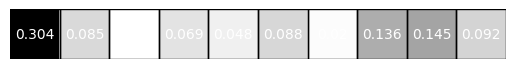

In [16]:
plt_logits(logits2)
logits2